# **Which of the playing teams in NHL have better public support and what is the overall public opinion on a particular team?**



In [1]:
!pip install emot

In [2]:
!pip install vaderSentiment

In [3]:
!pip install pyLDAvis

In [4]:
!pip install pandas_bokeh

In [5]:
!pip install spacy

In [6]:
import pandas as pd
import numpy as np
import re
import glob
import os
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from emot.emo_unicode import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
#nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [7]:
data_files = r"Tweets"
team_tweets_df= pd.DataFrame()
team_tweets_df= pd.concat(map(pd.read_csv,glob.glob(os.path.join(data_files,'Team*.csv'))), ignore_index= True)
team_tweets_df.to_csv("Team_Tweets_NHL.csv")
team_tweets_df.drop_duplicates(inplace=True)

In [8]:
# team_tweets_df = pd.read_csv("Team_tweets_17_03_2020.csv")
# team_tweets_df.shape
team_tweets_df.head(10)

,Team,Date,Tweet
0,Boston Bruins,2022-03-25 21:31:26+00:00,@PowellAnalytics Bobby Orr. Boston Bruins.
1,Boston Bruins,2022-03-25 21:23:57+00:00,Don't look now but Erik Haula has been hitting...
2,Boston Bruins,2022-03-25 21:23:23+00:00,Tuukka Rask of Boston Bruins earns tribute in ...
3,Boston Bruins,2022-03-25 21:15:52+00:00,"Or, according to the announcements, the Boston..."
4,Boston Bruins,2022-03-25 21:13:41+00:00,RT @BR_Athletics_MA: Huge congratulations to J...
5,Boston Bruins,2022-03-25 21:10:22+00:00,How DeBrusk feels about staying with Bruins de...
6,Boston Bruins,2022-03-25 21:09:36+00:00,Bruins' failure to add forward depth at trade ...
7,Boston Bruins,2022-03-25 21:09:23+00:00,"Bruins improved at trade deadline, but path to..."
8,Boston Bruins,2022-03-25 21:09:01+00:00,Bruins cement status as legit contender with s...
9,Boston Bruins,2022-03-25 21:07:43+00:00,RT @BitSler: 🏒#NHL in 15 min 🏒\n\nBET NOW ➡️ h...


# Tweets cleaning

Cleaning is an important step before performing text analysis. Before performing sentiment analysis, we used regular expressions to remove hyperlinks, hashtags, mentions of other twitter users starting with ‘@’, retweets starting with ‘RT’ and emojis.

In [9]:
#removing hyoerlinks
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'https?:\/\/.*[\r\n]*', '').str.strip()

#remove # and @ from tweets
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'@\w+|#\w+|RT|', '').str.strip()

In [10]:
# Removing Emojis
def handle_emojis(tweet):
    for emot in UNICODE_EMOJI:
        tweet = tweet.replace(emot, "")
    return tweet

team_tweets_df["Tweet"] = team_tweets_df["Tweet"].apply(handle_emojis)

# Sentiment Stats of each team

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER is used to quantify how much positive or negative emotion the text has.Here, SentimentIntensityAnalyzer() is an object and polarity_scores method returns a dict having positive, negative, neutral and compound scores. The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text. For our case, we concluded that the tweets with compound scores between 0.5 and 1 are positive, -0.5 and -1 as negative and remaining as neutral.


In [11]:
team_names = team_tweets_df["Team"].unique()
analyzer = SentimentIntensityAnalyzer()
pd.options.mode.chained_assignment = None

Team_arr = []
positive_scores = []
negative_scores = []
neutral_scores = []

def determine_polarity(tweet):
    pol_scores = analyzer.polarity_scores(tweet) 
    compound_score = pol_scores["compound"]
    if compound_score >= 0.5:
        return "positive"
    elif compound_score <= -0.5:
        return "negative"
    else:
        return "neutral"
team_tweets_df1 = pd.DataFrame()    
for team in team_names:
    curr_team_df = team_tweets_df.loc[team_tweets_df["Team"] == team]
    curr_team_df["polarity"] = curr_team_df["Tweet"].apply(determine_polarity)
    team_tweets_df1 = team_tweets_df1.append(curr_team_df)
    pos_num = curr_team_df[curr_team_df["polarity"]== "positive"].count()["Tweet"]
    neg_num = curr_team_df[curr_team_df["polarity"]== "negative"].count()["Tweet"]
    neu_num = curr_team_df[curr_team_df["polarity"]== "neutral"].count()["Tweet"]
    
    Team_arr.append(team)
    positive_scores.append(pos_num)
    negative_scores.append(neg_num)
    neutral_scores.append(neu_num)
    
    print("\n=========== ",team ," Tweets Sentiment Stats: =================")
    print("Positive Tweets: ", pos_num)
    print("Negative Tweets: ", neg_num)
    print("Neutral Tweets:  ", neu_num)

Team_sentiment_stats_df = pd.DataFrame({"Team" : Team_arr,
                              "Positive_tweet" : positive_scores,
                              "Negative_tweet" : negative_scores,
                              "Neutral_tweet" : neutral_scores
                                       })
print(Team_sentiment_stats_df)

Team_sentiment_stats_df.to_csv('Teams_sentiment.csv')


===========  Boston Bruins  Tweets Sentiment Stats: =================
Positive Tweets:  918
Negative Tweets:  200
Neutral Tweets:   2381

===========  Buffalo Sabres  Tweets Sentiment Stats: =================
Positive Tweets:  1236
Negative Tweets:  119
Neutral Tweets:   2075

===========  Detroit Red Wings  Tweets Sentiment Stats: =================
Positive Tweets:  692
Negative Tweets:  199
Neutral Tweets:   2425

===========  Florida Panthers  Tweets Sentiment Stats: =================
Positive Tweets:  907
Negative Tweets:  106
Neutral Tweets:   2482

===========  Montreal Canadiens  Tweets Sentiment Stats: =================
Positive Tweets:  677
Negative Tweets:  114
Neutral Tweets:   2703

===========  Ottawa Senators  Tweets Sentiment Stats: =================
Positive Tweets:  667
Negative Tweets:  126
Neutral Tweets:   2443

===========  Tampa Bay Lightning  Tweets Sentiment Stats: =================
Positive Tweets:  849
Negative Tweets:  168
Neutral Tweets:   2276

===========

In [12]:
team_tweets_df1.head(5)

,Team,Date,Tweet,polarity
0,Boston Bruins,2022-03-25 21:31:26+00:00,Bobby Orr. Boston Bruins.,neutral
1,Boston Bruins,2022-03-25 21:23:57+00:00,Don't look now but Erik Haula has been hitting...,neutral
2,Boston Bruins,2022-03-25 21:23:23+00:00,Tuukka Rask of Boston Bruins earns tribute in ...,neutral
3,Boston Bruins,2022-03-25 21:15:52+00:00,"Or, according to the announcements, the Boston...",neutral
4,Boston Bruins,2022-03-25 21:13:41+00:00,: Huge congratulations to Justin Peters who wi...,positive


In [14]:
data_senti = Team_sentiment_stats_df[['Team','Positive_tweet','Negative_tweet']]
data_senti.set_index('Team', inplace=True)
data_senti['Negative_tweet'] = data_senti['Negative_tweet'] * (-1)
#data_senti.sort_values(by = "Positive_tweet", inplace = True, ascending = True)
#data_senti

In [15]:
import pandas_bokeh
pandas_bokeh.output_notebook()

In [16]:

#from plot_bokeh import barh
data_senti.plot_bokeh.barh(title='Fans Sentiment towards NHL Teams')

Figure(id='1038', ...)

# Topic Modelling - LDA and LSI

A Topic Model is a type of statistical model for discovering the abstract “topics” that occur in a collection of documents.

Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

Latent Semantic Indexing, also known as latent semantic analysis, is a mathematical practice that helps classify and retrieve information on particular key terms and concepts using singular value decomposition (SVD).


In [17]:
#remove punctuation
team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].str.replace('[{}]'.format(string.punctuation), '')

In [18]:
#remove stop words
import nltk
nltk.download('stopwords')
stop_wrds = stopwords.words('english')

def stop_word_removal(tweet):
    return ' '.join([word for word in tweet.split() if word not in stop_wrds])

team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].apply(stop_word_removal)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#tokenization
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True)

def tokenization(tweet):
    token_sent = tokenizer.tokenize(tweet)
    return token_sent

team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].apply(tokenization)
# team_tweets_df.to_csv('check.csv', index = False)

In [20]:
#lemmatization
import spacy 
def lemmatization(texts, team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    split_team = str.lower(team_name).split()
    split_team.append(split_team[-1][:-1])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.lemma_ not in split_team) and (len(token.lemma_) > 3)]))
    return texts_out

nlp = spacy.load("en_core_web_sm")
#keeping only Noun, Adj, Verb, Adverb
positive_team_name = Team_sentiment_stats_df.iloc[Team_sentiment_stats_df["Positive_tweet"].idxmax()]["Team"]
positive_team_df =  team_tweets_df1.loc[team_tweets_df1["Team"] == positive_team_name]
positive_team_df["Tweet"] = lemmatization(positive_team_df["Tweet"], positive_team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
positive_team_df.head(5)

,Team,Date,Tweet,polarity
500,Buffalo Sabres,2022-03-25 22:33:41+00:00,,neutral
501,Buffalo Sabres,2022-03-25 22:30:03+00:00,free pick capital preview prediction,positive
502,Buffalo Sabres,2022-03-25 22:28:24+00:00,today pick capital pick available,neutral
503,Buffalo Sabres,2022-03-25 22:26:21+00:00,roll month keep trend tonight,neutral
504,Buffalo Sabres,2022-03-25 22:25:56+00:00,more tonight game capital ovechkin dominance y...,neutral


In [21]:
#Hyperparameter tuning for LDA model
def lda_hyperparameter(team_df):
  vectorizer = CountVectorizer(analyzer='word',       
                               min_df=10,                        
                               stop_words='english',             
                               lowercase=True,                   
                               #ngram_range=(1, 2)
                              )

  data_vectorized = vectorizer.fit_transform(positive_team_df["Tweet"])

  #Checking the sparsity of the data
  data_dense = data_vectorized.todense()
  print("sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
  # Define Search Param
  search_params = {'n_components': [3, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

  # Init the Model
  lda = LatentDirichletAllocation()

  # Init Grid Search Class
  model = GridSearchCV(lda, param_grid=search_params)

  # Do the Grid Search
  model.fit(data_vectorized)

  # Best Model
  best_lda_model = model.best_estimator_

  # Model Parameters
  print("Best Model's Params: ", model.best_params_)

  # Log Likelihood Score
  print("Best Log Likelihood Score: ", model.best_score_)

  # Perplexity
  print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

  n_topics = [3, 10, 15, 20, 25, 30]
  #print(model.cv_results_)
  scores_mean = model.cv_results_['mean_test_score'].tolist()
  print(scores_mean)
  log_likelyhoods_5 = scores_mean[0:6]
  log_likelyhoods_7 = scores_mean[6:12]
  log_likelyhoods_9 = scores_mean[12:18]

  # Show graph
  plt.figure(figsize=(12, 8))
  plt.plot(n_topics, log_likelyhoods_5, label='0.5')
  plt.plot(n_topics, log_likelyhoods_7, label='0.7')
  plt.plot(n_topics, log_likelyhoods_9, label='0.9')
  plt.title("Choosing Optimal LDA Model")
  plt.xlabel("Num Topics")
  plt.ylabel("Log Likelyhood Scores")
  plt.legend(title='Learning decay', loc='best')
  plt.show()

  return best_lda_model, data_vectorized, vectorizer 

sparsity:  1.088182954072167 %
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -14578.222070802678
Model Perplexity:  167.56860044510776
[-14599.320243671065, -15723.253041317934, -16399.621416226775, -16847.666597581712, -17301.720508412465, -17639.96181242576, -14578.222070802678, -15828.859947376292, -16246.50126078667, -16812.8036650123, -17109.262671000175, -17779.353304433615, -14644.892312540813, -15648.418259550894, -16244.644895039248, -16755.20086513456, -17109.240836399218, -17599.151915629507]


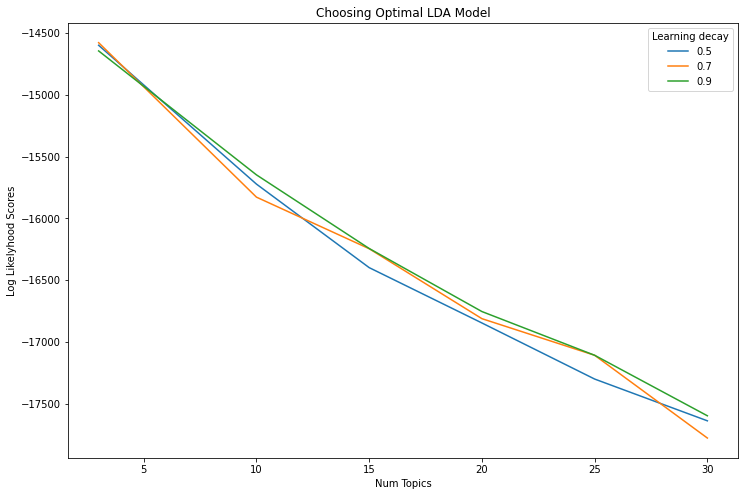

In [22]:
#Best LDA model for positive team
best_lda_model, data_vectorized, vectorizer = lda_hyperparameter(positive_team_df)

In [23]:
#visualization for LDA
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  34.898476
0      -387.996002  -373.316162       2        1  32.816820
2     -2184.745605   -60.565800       3        1  32.284705, topic_info=          Term        Freq       Total Category  logprob  loglift
294       want  386.000000  386.000000  Default  30.0000  30.0000
59      energy  347.000000  347.000000  Default  29.0000  29.0000
132  legendary  315.000000  315.000000  Default  28.0000  28.0000
111      honor  314.000000  314.000000  Default  27.0000  27.0000
226      score  211.000000  211.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
91        good   79.417609  149.831401   Topic3  -3.8792   0.4958
272      today   39.685629   54.102030   Topic3  -4.5730   0.8207
227     season   57.656833  166.743068   Topic3  -4.1995   0.0686
183       play   39.253068  123.193670   Topic3  -4.5839  -0.0132
295      watch   35.414769   80.868136   Topic3  -4.6868   0.3049

[154 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         3  0.983982      ahead
8         2  0.980450   announce
11        1  0.980737     assist
12        3  0.978077  available
17        1  0.984672       beat
...     ...       ...        ...
295       3  0.432803      watch
297       3  0.989310       week
305       1  0.054485       year
305       3  0.942595       year
306       3  0.984783  yesterday

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

The below are the public opinions for the team that has good public support

- Topic 1 - game stats.
- Topic 2 - Tage Thompson's recent performance
- Topic 3 - Fan's support and celebration over wins.

In [24]:
#showing first 15 topics for positive team
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,want,energy,legendary,honor,penguin,capital,tage,game,preview,lift,shootout,return,source,season,announce
Topic 1,score,game,team,point,tonight,make,goal,support,play,playoff,night,sale,bring,celebrate,throwback
Topic 2,year,team,time,trade,good,look,know,come,love,sport,join,season,talk,prospect,head


Text(0.5, 1.0, 'Segregation of Topic Clusters')

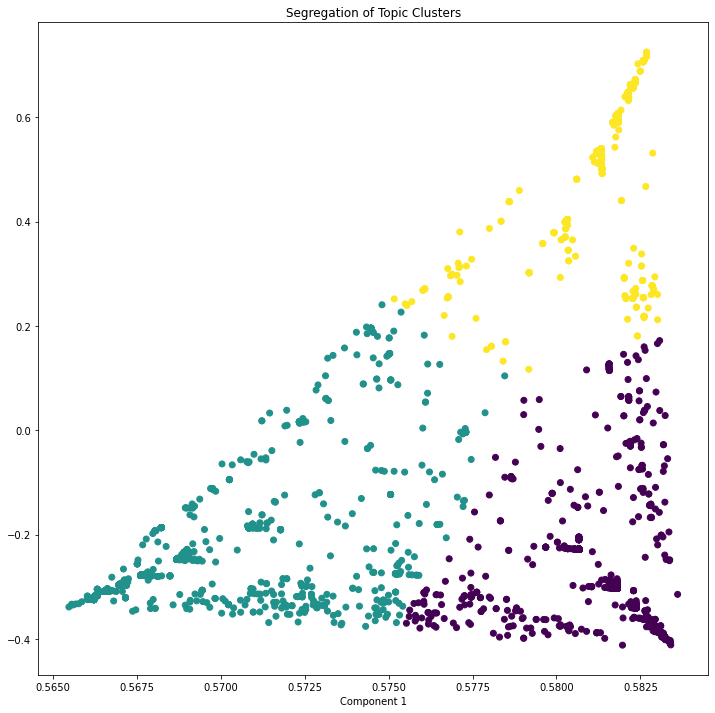

In [25]:
#visualize the clusters of documents in a 2D space
from sklearn.cluster import KMeans
lda_output = best_lda_model.transform(data_vectorized)
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [26]:
#LSI model for positive team
import gensim
import gensim.corpora as corpora
from pprint import pprint

data_lemma = positive_team_df["Tweet"].to_numpy()
unicode_dataset = [d.split() for d in data_lemma]
id2word = corpora.Dictionary(unicode_dataset)
texts = unicode_dataset
corpus = [id2word.doc2bow(text) for text in texts]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]] 
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=3,chunksize=100)
pprint(lsi_model.print_topics())

[(0,
  '0.517*"want" + 0.502*"energy" + 0.490*"legendary" + 0.490*"honor" + '
  '0.020*"team" + 0.015*"love" + 0.012*"bill" + 0.012*"sport" + 0.011*"join" + '
  '0.010*"excited"'),
 (1,
  '0.514*"team" + 0.287*"game" + 0.273*"back" + 0.263*"bring" + '
  '0.258*"throwback" + 0.243*"support" + 0.231*"sale" + 0.226*"throw" + '
  '0.176*"capital" + 0.140*"goal"'),
 (2,
  '0.436*"game" + 0.294*"capital" + -0.254*"bring" + -0.252*"throwback" + '
  '-0.232*"sale" + -0.231*"support" + -0.226*"throw" + 0.212*"score" + '
  '0.211*"goal" + -0.200*"back"')]


The LSI model's results are similar to LDA's.

In [27]:
#keeping only Noun, Adj, Verb, Adverb
negative_team_name = Team_sentiment_stats_df.iloc[Team_sentiment_stats_df["Negative_tweet"].idxmax()]["Team"]
negative_team_df =  team_tweets_df1.loc[team_tweets_df1["Team"] == negative_team_name]
negative_team_df = negative_team_df[negative_team_df["polarity"] == "negative"]
negative_team_df["Tweet"] = lemmatization(negative_team_df["Tweet"], negative_team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
negative_team_df.head(5)

,Team,Date,Tweet,polarity
9002,New Jersey Devils,2022-03-25 22:47:56+00:00,blackdevil just follow also nickname black sur...,negative
9003,New Jersey Devils,2022-03-25 22:41:47+00:00,request,negative
9010,New Jersey Devils,2022-03-25 21:47:22+00:00,last game play exemplify season turn early def...,negative
9011,New Jersey Devils,2022-03-25 21:41:27+00:00,capital,negative
9014,New Jersey Devils,2022-03-25 20:38:47+00:00,,negative


sparsity:  1.088182954072167 %
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -14649.958721763853
Model Perplexity:  161.15109523933563
[-14649.958721763853, -15877.691182572424, -16334.919075513568, -16876.819580409392, -17106.939181622576, -17622.11591487797, -14698.21356369621, -15794.085088473948, -16293.63812508464, -16809.306708135402, -17287.97514382099, -17656.213791424085, -14682.483476678903, -15775.559858369428, -16309.875185152521, -16804.34927135362, -17217.81851690286, -17690.925167988124]


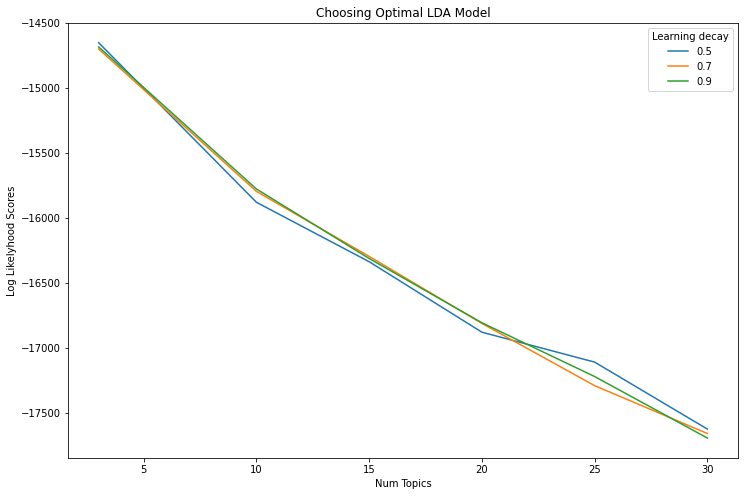

In [28]:
#best lda model for negative team
best_lda_model, data_vectorized, vectorizer = lda_hyperparameter(negative_team_df)

In [29]:
#LDA visualization for negative team
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  36.227671
0      -387.996002  -373.316162       2        1  33.200772
2     -2184.745605   -60.565800       3        1  30.571557, topic_info=          Term        Freq       Total Category  logprob  loglift
294       want  397.000000  397.000000  Default  30.0000  30.0000
59      energy  357.000000  357.000000  Default  29.0000  29.0000
132  legendary  324.000000  324.000000  Default  28.0000  28.0000
111      honor  323.000000  323.000000  Default  27.0000  27.0000
226      score  209.000000  209.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
260       team  128.632610  339.331713   Topic3  -3.3425   0.2151
240     source   38.330910   57.025327   Topic3  -4.5532   0.7879
227     season   61.032522  166.905115   Topic3  -4.0880   0.1791
100       head   28.266872   53.003315   Topic3  -4.8578   0.5564
271       time   31.177730  115.858166   Topic3  -4.7597  -0.1276

[146 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.972359      ahead
8         1  0.993855   announce
16        3  0.980135       bear
17        2  0.993116       beat
22        3  0.997646      bring
...     ...       ...        ...
295       1  0.994118      watch
297       1  0.983357       week
305       1  0.873709       year
305       3  0.121656       year
306       1  0.974010  yesterday

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

The below are the public opinions for the team that has good public support

- Topic 1 - game stats.
- Topic 2 - Loss due to Jack Hughes injury.
- Topic 3 - Fan's support as well as criticism

In [30]:
#top 15 words per topic
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,game,score,penguin,goal,capital,point,tage,preview,shootout,lift,pick,celebrate,streak,loss,season
Topic 1,team,year,tonight,good,make,play,game,watch,know,love,come,look,sport,oiler,playoff
Topic 2,want,energy,legendary,honor,team,trade,bring,throwback,support,sale,throw,return,season,tell,forward


Text(0.5, 1.0, 'Segregation of Topic Clusters')

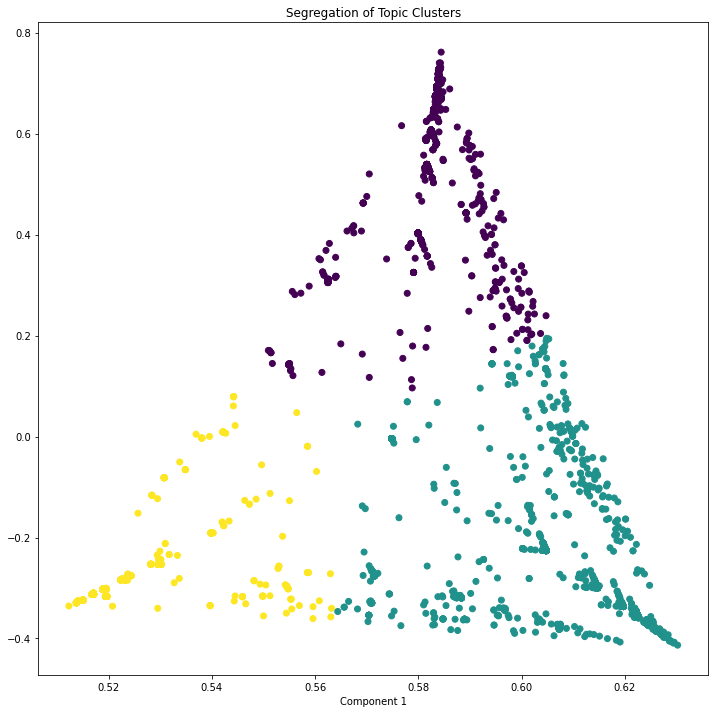

In [31]:
#visualize the clusters of documents in a 2D space - negative team
lda_output = best_lda_model.transform(data_vectorized)
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [32]:
#LSI model for negative team
data_lemma = negative_team_df["Tweet"].to_numpy()
unicode_dataset = [d.split() for d in data_lemma]
id2word = corpora.Dictionary(unicode_dataset)
texts = unicode_dataset
corpus = [id2word.doc2bow(text) for text in texts]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]] 
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=3,chunksize=100)
pprint(lsi_model.print_topics())

[(0,
  '0.433*"score" + 0.418*"goal" + 0.357*"history" + 0.356*"become" + '
  '0.354*"ever" + 0.354*"player" + 0.354*"abuse" + 0.036*"defeat" + '
  '0.023*"game" + 0.022*"beat"'),
 (1,
  '0.433*"lose" + 0.376*"playoff" + 0.376*"eliminate" + 0.376*"contention" + '
  '0.367*"regulation" + 0.345*"tonight" + 0.310*"montreal" + 0.075*"canuck" + '
  '0.062*"second" + 0.059*"game"'),
 (2,
  '0.416*"game" + 0.390*"flame" + 0.266*"defeat" + 0.262*"canuck" + '
  '0.215*"goal" + 0.198*"score" + 0.169*"season" + 0.158*"islander" + '
  '0.145*"capital" + -0.139*"abuse"')]


The LSI model's results are similar to that of LDA's